# House pricing project
## Using regression methods

## importing essential libraries

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

### read the csv file and take a look at it

In [73]:
df = pd.read_csv("housePrice.csv")
df.describe()
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


### Cleaning dataset
- Dropping nan elements
- Converting True/False to 1/0 & Address labels two unique numbers
- Dropping Areas with non-numeric values
- Bounding Areas to less than $250m^2$

In [74]:
cdf = df.dropna(how='any', axis=0).copy()
cdf["Address"].isnull().sum()

cdf["Area"] = pd.to_numeric(cdf["Area"], errors="coerce")
cdf.dropna(subset="Area", inplace=True)
cdf = cdf[cdf["Area"] <= 250]

cdf["Warehouse"] = cdf["Warehouse"].astype(int)
cdf["Parking"] = cdf["Parking"].astype(int)
cdf["Elevator"] = cdf["Elevator"].astype(int)

# Create a mapping from unique addresses to numbers
address_mapping = {address: idx + 1 for idx, address in enumerate(cdf["Address"].unique())}

# Map the addresses to their corresponding numbers
cdf["Address"] = cdf["Address"].map(address_mapping)

cdf.describe()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
count,3351.000000,3351.000000,3351.000000,3351.000000,3351.000000,3351.000000,3.351000e+03,3.351000e+03
mean,98.347657,2.033124,0.844524,0.915249,0.794091,45.026559,4.575266e+09,1.525089e+05
std,41.344515,0.694826,0.362412,0.278552,0.404424,38.722613,5.381167e+09,1.793722e+05
min,30.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.600000e+06,1.200000e+02
25%,68.000000,2.000000,1.000000,1.000000,1.000000,11.000000,1.380000e+09,4.600000e+04
50%,90.000000,2.000000,1.000000,1.000000,1.000000,34.000000,2.800000e+09,9.333333e+04
75%,117.000000,2.000000,1.000000,1.000000,1.000000,69.000000,5.600000e+09,1.866667e+05
max,250.000000,5.000000,1.000000,1.000000,1.000000,187.000000,4.690000e+10,1.563333e+06


### Let's seperate the 80% of training data from 20% of test data

In [78]:
msk = np.random.rand(len(cdf)) < 0.8
train = cdf[msk]
test = cdf[~msk]

### Now it's time to scatter which parameters affects on price

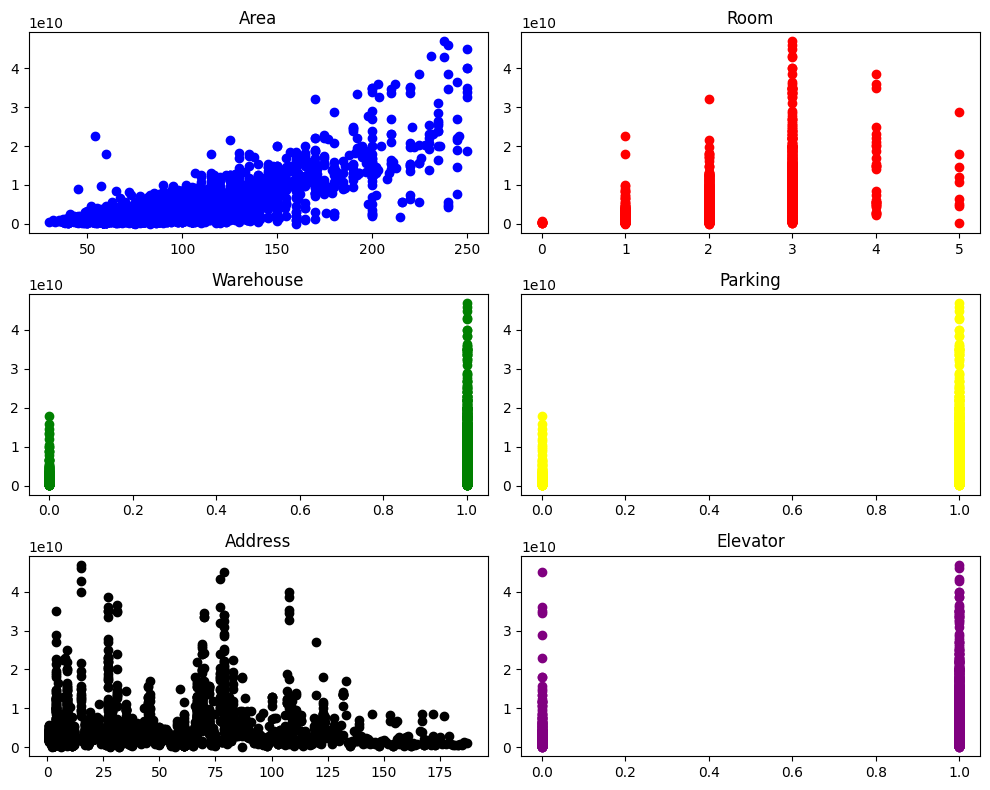

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# First scatter
axes[0, 0].scatter(cdf.Area, cdf.Price, color='blue')
axes[0, 0].set_title('Area')

# Second scatter
axes[0, 1].scatter(cdf.Room, cdf.Price, color='red')
axes[0, 1].set_title('Room')

# Third scatter
axes[1, 0].scatter(cdf.Warehouse, cdf.Price, color='green')
axes[1, 0].set_title('Warehouse')

# Fourth scatter
axes[1, 1].scatter(cdf.Parking, cdf.Price, color='yellow')
axes[1, 1].set_title('Parking')

axes[2, 1].scatter(cdf.Elevator, cdf.Price, color='purple')
axes[2, 1].set_title('Elevator')

axes[2, 0].scatter(cdf.Address, cdf.Price, color='black')
axes[2, 0].set_title('Address')

plt.tight_layout()
plt.show()

### Let's import scikit learn functions
    to check how should we train our model

In [80]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# Take Area + Address for polynomial expansion
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(np.asanyarray(train[["Area", "Address"]]))
poly_features_ = poly.transform(np.asanyarray(test[["Area", "Address"]]))

# Keep Warehouse, Parking, Elevator, Room as linear
other_features = np.asanyarray(train[["Warehouse", "Parking", "Elevator", "Room"]])
other_features_ = np.asanyarray(test[["Warehouse", "Parking", "Elevator", "Room"]])

# Combine polynomial + linear features
train_x = np.hstack([poly_features, other_features])
test_x = np.hstack([poly_features_, other_features_])

# Target
train_y = np.asanyarray(train[["Price"]])
test_y = np.asanyarray(test[["Price"]])

# Train model --> regr
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

print(regr.coef_, regr.intercept_)

[[-6.49398768e+07 -1.96875659e+07  6.79702698e+05  4.39631239e+05
   2.53589508e+05 -8.63587366e+01 -1.04737979e+03 -1.29289723e+03
  -1.23302203e+03  4.56010437e+08  8.85954668e+08  8.04189684e+08
  -4.92206518e+08]] [2.0492689e+09]


### Let's Evaluate the model
    for the accuracy of the model

In [81]:
from sklearn.metrics import r2_score

test_y_hat_regr = regr.predict(test_x)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat_regr - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat_regr - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y_hat_regr ) )

Mean absolute error: 1676387771.86
Residual sum of squares (MSE): 7650657262619680768.00
R2-score: 0.72


### For better accuracy
    I consider to fit the Room and Address parameter
    by one-hot-encoder method.

In [82]:
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression

poly_features = ["Area"]                # polynomial expansion
onehot_features = ["Address", "Room"]   # categorical one-hot
linear_features = ["Warehouse", "Parking", "Elevator"]  # linear

# Polynomial expansion (Area)
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_area = poly.fit_transform(np.asanyarray(train[poly_features]))
poly_area_ = poly.transform(np.asanyarray(test[poly_features]))

# One-hot encoding (Address, Room)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
onehot = ohe.fit_transform(train[onehot_features])
onehot_ = ohe.transform(test[onehot_features])

# Linear features (kept as-is)
linear = np.asanyarray(train[linear_features])
linear_ = np.asanyarray(test[linear_features])

# Combine everything
train_x = np.hstack([poly_area, onehot, linear])
test_x  = np.hstack([poly_area_, onehot_, linear_])

train_y = np.asanyarray(train[["Price"]])
test_y  = np.asanyarray(test[["Price"]])

# Fit regression model
model = LinearRegression()
model.fit(train_x, train_y)

print("Intercept:", model.intercept_)
print("Coefficients shape:", model.coef_.shape)

Intercept: [5.33740656e+08]
Coefficients shape: (1, 196)


### Let's Evaluate model
    we considered categorical fitness
    for Address and Room

In [83]:
from sklearn.metrics import r2_score

test_y_hat_model = model.predict(test_x)
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat_model - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat_model - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y_hat_model))

Mean absolute error: 1137460562.28
Residual sum of squares (MSE): 4945388148954447872.00
R2-score: 0.82


### Final comparison is to check both plots
### of **regr** and **model** on scattered prediction
Also R2-score of each printed to find out the best applied model

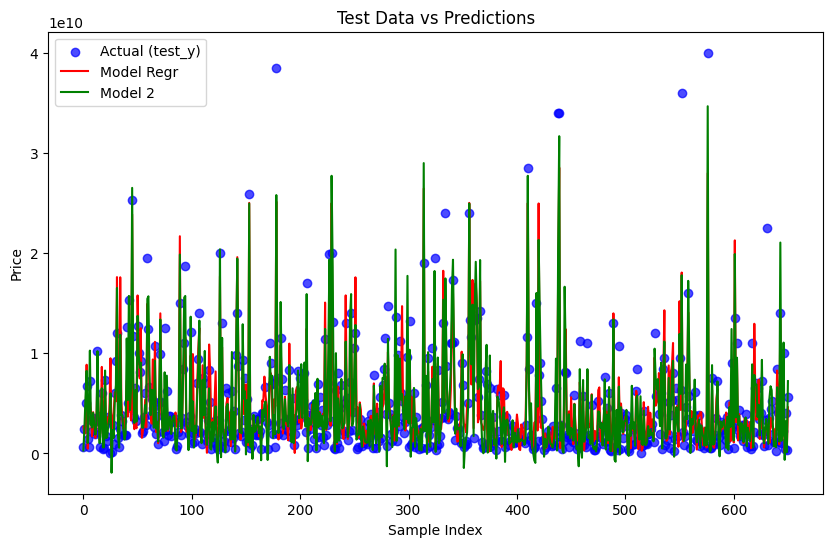

R2-Score of regr: 0.7171
R2-Score of model: 0.8171


In [84]:
x_axis = np.arange(len(test_y))
plt.figure(figsize=(10,6))

# Scatter of true values (blue)
plt.scatter(x_axis, test_y, color="blue", label="Actual (test_y)", alpha=0.7)

# Plot predictions from both models
plt.plot(x_axis, test_y_hat_regr, color="red", label="Model Regr")
plt.plot(x_axis, test_y_hat_model, color="green", label="Model 2")

plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Test Data vs Predictions")
plt.legend()
plt.show()

print("R2-Score of regr: %.4f" %r2_score(test_y,test_y_hat_regr))
print("R2-Score of model: %.4f" %r2_score(test_y,test_y_hat_model))